In [1]:
"""These are assumed to be ran after the production database is updated"""

import pandas as pd
import plotly.express as px

from mainnet_launch.database.postgres_operations import (
    _exec_sql_and_cache,
    get_full_table_as_df_with_tx_hash,
    get_full_table_as_df_with_block,
    get_full_table_as_df,
)
from mainnet_launch.database.schema.full import *

from mainnet_launch.slack_messages.post_message import post_slack_message, post_message_with_table
from mainnet_launch.constants import *


# claim vault rewards on the liqudation row contract
from mainnet_launch.abis import TOKEMAK_LIQUIDATION_ROW_ABI
from mainnet_launch.constants import LIQUIDATION_ROW2, LIQUIDATION_ROW

from mainnet_launch.data_fetching.get_events import fetch_events
from mainnet_launch.data_fetching.get_state_by_block import get_raw_state_by_blocks


def fetch_all_balance_updated_events() -> str:

    all_balance_updated = []
    for chain in ALL_CHAINS:

        liquidation_row1_contract = chain.client.eth.contract(
            address=LIQUIDATION_ROW(chain), abi=TOKEMAK_LIQUIDATION_ROW_ABI
        )

        liquidation_row2_contract = chain.client.eth.contract(
            address=LIQUIDATION_ROW2(chain), abi=TOKEMAK_LIQUIDATION_ROW_ABI
        )

        balanceUpdated_1 = fetch_events(
            event=liquidation_row1_contract.events.BalanceUpdated,
            chain=chain,
        )

        balance_updated_2 = fetch_events(
            event=liquidation_row2_contract.events.BalanceUpdated,
            chain=chain,
        )

        balance_updated = pd.concat([balanceUpdated_1, balance_updated_2], ignore_index=True)
        blocks = balance_updated["block"].unique().tolist()
        if not blocks:
            continue

        block_datetimes = get_raw_state_by_blocks(calls=[], chain=chain, blocks=blocks, include_block_number=True)

        block_to_datetime = block_datetimes.reset_index().set_index("block")["timestamp"].to_dict()
        balance_updated["datetime"] = balance_updated["block"].map(block_to_datetime)
        all_balance_updated.append(balance_updated)

    df = pd.concat(all_balance_updated, ignore_index=True)
    df.rename(columns={"token": "token_address", "vault": "destination_vault_address"}, inplace=True)
    return df


def fetch_recent_vault_claimed_reward_events(n: int) -> str:
    balance_updated_events = fetch_all_balance_updated_events()

    n_days_ago = pd.Timestamp.now() - pd.Timedelta(days=n)

    get_recent_autopool_destination_states_query = f"""
              SELECT
                  autopool_destination_states.*,
                  destinations.pool as pool,
                  blocks.datetime
              FROM autopool_destination_states
              JOIN blocks
                ON autopool_destination_states.block = blocks.block
              AND autopool_destination_states.chain_id = blocks.chain_id
              JOIN destinations
                ON autopool_destination_states.destination_vault_address = destinations.destination_vault_address
                AND autopool_destination_states.chain_id = destinations.chain_id

              WHERE blocks.datetime > '{n_days_ago}'
              ORDER BY blocks.datetime DESC
    """

    get_recent_destination_states_query = f"""

          SELECT
          destination_states.*,
          destinations.pool as pool,
          blocks.datetime
          FROM destination_states
          JOIN blocks
          ON destination_states.block = blocks.block
          AND destination_states.chain_id = blocks.chain_id

          JOIN destinations
          ON destination_states.destination_vault_address = destinations.destination_vault_address
          AND destination_states.chain_id = destinations.chain_id

          WHERE blocks.datetime > '{n_days_ago}'
          ORDER BY blocks.datetime DESC           

    """
    destination_states = _exec_sql_and_cache(get_recent_destination_states_query)

    autopool_destination_states = _exec_sql_and_cache(get_recent_autopool_destination_states_query)

    autopool_destinations = get_full_table_as_df(AutopoolDestinations)
    autopool_destinations["autopool_name"] = autopool_destinations["autopool_vault_address"].map(
        {a.autopool_eth_addr: a.name for a in ALL_AUTOPOOLS}
    )
    destinations = get_full_table_as_df(Destinations)
    autopool_destinations = pd.merge(
        autopool_destinations, destinations, on=["destination_vault_address", "chain_id"], how="left"
    )
    return balance_updated_events, destination_states, autopool_destination_states, autopool_destinations


# 8 days to catch morpho
balance_updated_events, destination_states, autopool_destination_states, autopool_destinations = (
    fetch_recent_vault_claimed_reward_events(n=8)
)

/Users/pb/Library/Caches/pypoetry/virtualenvs/mainnet-launch-FtycU18g-py3.10/lib/python3.10/site-packages/web3/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Fetched 8,360 logs for <class 'web3._utils.datatypes.BalanceUpdated'> from 20,722,908 to 23,649,079 (2,926,172 blocks)


/Users/pb/Library/Caches/pypoetry/virtualenvs/mainnet-launch-FtycU18g-py3.10/lib/python3.10/site-packages/web3/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/pb/Library/Caches/pypoetry/virtualenvs/mainnet-launch-FtycU18g-py3.10/lib/python3.10/site-packages/web3/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/pb/Library/Caches/pypoetry/virtualenvs/mainnet-launch-FtycU18g-py3.10/lib/python3.10/site-packages/web3/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest

Retryable failure when fetching logs for <class 'web3._utils.datatypes.BalanceUpdated'> on chain.name='eth'from 20,722,908 to 23,649,079 (2,926,172 blocks), splitting into:
  - 20,722,908 to 22,185,993 (1,463,086 blocks)
  - 22,185,994 to 23,649,079 (1,463,086 blocks)
Fetched 0 logs for <class 'web3._utils.datatypes.BalanceUpdated'> from 20,722,908 to 22,185,993 (1,463,086 blocks)
Retryable failure when fetching logs for <class 'web3._utils.datatypes.BalanceUpdated'> on chain.name='eth'from 22,185,994 to 23,649,079 (1,463,086 blocks), splitting into:
  - 22,185,994 to 22,917,536 (731,543 blocks)
  - 22,917,537 to 23,649,079 (731,543 blocks)
Fetched 8,468 logs for <class 'web3._utils.datatypes.BalanceUpdated'> from 22,185,994 to 22,917,536 (731,543 blocks)
Fetched 4,751 logs for <class 'web3._utils.datatypes.BalanceUpdated'> from 22,917,537 to 23,649,079 (731,543 blocks)


/Users/pb/Library/Caches/pypoetry/virtualenvs/mainnet-launch-FtycU18g-py3.10/lib/python3.10/site-packages/web3/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/pb/Library/Caches/pypoetry/virtualenvs/mainnet-launch-FtycU18g-py3.10/lib/python3.10/site-packages/web3/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/pb/Library/Caches/pypoetry/virtualenvs/mainnet-launch-FtycU18g-py3.10/lib/python3.10/site-packages/web3/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest

Fetched 1,214 logs for <class 'web3._utils.datatypes.BalanceUpdated'> from 21,241,103 to 37,270,395 (16,029,293 blocks)
Fetched 2,286 logs for <class 'web3._utils.datatypes.BalanceUpdated'> from 21,241,103 to 37,270,395 (16,029,293 blocks)
Fetching pre split sonic chunk from 31,593,624 to 33,593,623Fetching pre split sonic chunk from 33,593,624 to 35,593,623
Fetching pre split sonic chunk from 35,593,624 to 37,593,623

Fetching pre split sonic chunk from 37,593,624 to 39,593,623
Fetching pre split sonic chunk from 39,593,624 to 41,593,623
Fetching pre split sonic chunk from 41,593,624 to 43,593,623
Fetching pre split sonic chunk from 43,593,624 to 45,593,623
Fetching pre split sonic chunk from 45,593,624 to 47,593,623
Fetched 1 logs for <class 'web3._utils.datatypes.BalanceUpdated'> from 39,593,624 to 41,593,623 (2,000,000 blocks)
Fetching pre split sonic chunk from 47,593,624 to 49,593,623
Fetched 14 logs for <class 'web3._utils.datatypes.BalanceUpdated'> from 41,593,624 to 43,593,623

In [2]:
balance_updated_events

,event,block,transaction_index,log_index,hash,token_address,destination_vault_address,balance,datetime
0,BalanceUpdated,20778361,110,291,0x2ca9da5c091439e2180d2e0ac07446369a20eb4fad45...,0xC0c293ce456fF0ED870ADd98a0828Dd4d2903DBF,0x6DcB6797b1C0442587c2ad79745ef7BB487Fc2E2,41397742589802445921,2024-09-18 15:25:59+00:00
1,BalanceUpdated,20778361,110,292,0x2ca9da5c091439e2180d2e0ac07446369a20eb4fad45...,0xba100000625a3754423978a60c9317c58a424e3D,0x6DcB6797b1C0442587c2ad79745ef7BB487Fc2E2,18233236064321120743,2024-09-18 15:25:59+00:00
2,BalanceUpdated,20778361,110,298,0x2ca9da5c091439e2180d2e0ac07446369a20eb4fad45...,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,0x4E12227b350E8f8fEEc41A58D36cE2fB2e2d4575,87393607,2024-09-18 15:25:59+00:00
3,BalanceUpdated,20778361,110,308,0x2ca9da5c091439e2180d2e0ac07446369a20eb4fad45...,0xC0c293ce456fF0ED870ADd98a0828Dd4d2903DBF,0x2F7e096a400ded5D02762120b39A3aA4ABA072a4,162030155527041797584,2024-09-18 15:25:59+00:00
4,BalanceUpdated,20778361,110,309,0x2ca9da5c091439e2180d2e0ac07446369a20eb4fad45...,0xba100000625a3754423978a60c9317c58a424e3D,0x2F7e096a400ded5D02762120b39A3aA4ABA072a4,31533671624096353080,2024-09-18 15:25:59+00:00
...,...,...,...,...,...,...,...,...,...
25474,BalanceUpdated,51321307,0,8,0xb344a1313590dd568f15376aa5b578c39d5fafdd35fb...,0x2D0E0814E62D80056181F5cd932274405966e4f0,0xA9d35198aCF60EfD4EEab5CB81454aE9c265C6ac,2973535604767306074,2025-10-20 14:53:25+00:00
25475,BalanceUpdated,51513065,1,16,0x51dd2e4f4501a13c69b520484aa6793db72d5c554006...,0x2D0E0814E62D80056181F5cd932274405966e4f0,0xF628a2A6eA34c0f36cD331Cb2174627728E92768,1063231372998530270,2025-10-22 08:53:22+00:00
25476,BalanceUpdated,51513065,1,21,0x51dd2e4f4501a13c69b520484aa6793db72d5c554006...,0x2D0E0814E62D80056181F5cd932274405966e4f0,0xA9d35198aCF60EfD4EEab5CB81454aE9c265C6ac,4163696666159758733,2025-10-22 08:53:22+00:00
25477,BalanceUpdated,51659754,0,3,0x5ed7ac6d943e58514b1bf0fe78bb930e42a6f442c7ed...,0x2D0E0814E62D80056181F5cd932274405966e4f0,0xF628a2A6eA34c0f36cD331Cb2174627728E92768,763737392776689865,2025-10-23 14:53:22+00:00


In [5]:
def determine_destinations_that_should_have_some_claims(destination_states, autopool_destination_states):

    destinations_with_any_incentive_apr_recent_past = destination_states[(destination_states["incentive_apr"] > 0)][
        "destination_vault_address"
    ].unique()

    destinations_with_any_owned_shares = autopool_destination_states[(autopool_destination_states["owned_shares"] > 0)][
        "destination_vault_address"
    ].unique()

    destinations_that_should_have_some_claims = [
        d for d in destinations_with_any_incentive_apr_recent_past if d in destinations_with_any_owned_shares
    ]
    return destinations_that_should_have_some_claims


destinations_that_should_have_some_claims = determine_destinations_that_should_have_some_claims(
    destination_states, autopool_destination_states
)
most_recent_balance_updated = balance_updated_events.groupby("destination_vault_address")["datetime"].max()

In [ ]:
highest_recent_incentive_apr = (
    destination_states.groupby("destination_vault_address")["incentive_apr"].max() * 100
).to_dict()
highest_recent_owned_shares = (
    autopool_destination_states.groupby("destination_vault_address")["owned_shares"].max()
).to_dict()
most_recent_claims_by_destination = (
    balance_updated_events.groupby("destination_vault_address")["datetime"].max().to_dict()
)
autopool_destinations["most_recent_claim"] = autopool_destinations["destination_vault_address"].map(
    most_recent_claims_by_destination
)

autopool_destinations["time_since_last_claim"] = pd.Timestamp.now(tz="UTC") - autopool_destinations["most_recent_claim"]
autopool_destinations["days_since_last_claim"] = (
    autopool_destinations["time_since_last_claim"].dt.total_seconds() / 86400
)
autopool_destinations["highest_recent_incentive_apr"] = autopool_destinations["destination_vault_address"].map(
    highest_recent_incentive_apr
)
autopool_destinations["highest_recent_owned_shares"] = autopool_destinations["destination_vault_address"].map(
    highest_recent_owned_shares
)

# Plasma and Arb look like they are not claiming rewards getting no Balance Updated events for those autopools




In [ ]:
cols = [
    "autopool_name",
    "underlying_name",
    "time_since_last_claim",
    "highest_recent_incentive_apr",
    "highest_recent_owned_shares",
]
missing_dfs = []
sub_dfs = []

for autopool in ALL_AUTOPOOLS:
    sub_df = autopool_destinations[
        (autopool_destinations["destination_vault_address"].isin(destinations_that_should_have_some_claims))
        & (autopool_destinations["autopool_name"] == autopool.name)
    ].drop_duplicates()
    sub_dfs.append(sub_df)

    missing_claims_df = sub_df[
        (sub_df["time_since_last_claim"] > pd.Timedelta(days=7)) | (sub_df["time_since_last_claim"].isna())
    ]
    if missing_claims_df.empty:
        continue

    else:
        missing_dfs.append(missing_claims_df)

missing_df = pd.concat(missing_dfs, ignore_index=True)
missing_df["time_since_last_claim"] = missing_df["time_since_last_claim"].dt.floor("min")
# post_message_with_table(
#     f"Missing Expected LiqudatorRow.BalanceUpdated events", missing_df
# )

full_sub_df = pd.concat(sub_dfs, ignore_index=True)

In [ ]:
full_sub_df["days_since_last_claim"] = full_sub_df["time_since_last_claim"].dt.total_seconds() / 86400

In [46]:
full_sub_df[["highest_recent_owned_shares", "highest_recent_incentive_apr", "underlying_name", "autopool_name"]]

,highest_recent_owned_shares,highest_recent_incentive_apr,underlying_name,autopool_name
0,1.367525e+02,1.067909,pxETH/stETH,autoETH
1,8.615477e+02,1.067909,pxETH/stETH,autoETH
2,3.404180e+03,0.765987,weETH/WETH-ng,autoETH
3,3.909810e+02,4.161843,wstETH-rETH-sfrxETH-BPT,autoETH
4,7.598587e+02,1.988506,Curve.fi Factory Pool: ETHx-ETH,autoETH
5,7.694065e+02,1.650670,osETH/rETH,autoETH
6,2.273437e+01,2.642228,Balancer osETH-waWETH,autoETH
7,3.703822e+03,2.642228,Balancer osETH-waWETH,autoETH
8,6.253809e+02,0.146060,pxETH/wETH,autoETH
9,3.225219e+03,0.340580,Balancer Surge Fluid wstETH-wETH,autoETH


In [56]:
px.bar(
    full_sub_df,
    x="underlying_name",
    y="days_since_last_claim",
    title=f"Time Since Last Claim by Autopool Destination Vault",
    hover_data=["highest_recent_incentive_apr", "highest_recent_owned_shares", "autopool_name"],
).show()

In [ ]:
break

In [ ]:
px.bar(
    full_sub_df,
    x="autopool_name",
    y="days_since_last_claim",
    color="underlying_name",
    title="Time Since Last Claim by Autopool Destination Vault",
)

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['destination_vault_address', 'chain_id', 'autopool_vault_address', 'autopool_name', 'exchange_name', 'name', 'symbol', 'pool_type', 'pool', 'underlying', 'underlying_symbol', 'underlying_name', 'denominated_in', 'destination_vault_decimals', 'most_recent_claim', 'time_since_last_claim', 'highest_recent_incentive_apr', 'highest_recent_owned_shares'] but received: days_since_last_claim

In [ ]:
base_usd_destinations

,autopool_name,underlying_name,time_since_last_claim,highest_recent_incentive_apr,highest_recent_owned_shares
260,plasmaUSD,Fluid USDT0,NaT,5.760000,2.081382e+06
268,plasmaUSD,Ethena Surge sUSDe-waUSDT0,NaT,6.413608,4.697664e+06


In [ ]:
# for each autopool, show a chart (say bar chart) for all destinations (with allocation)
# where the dests with incentives have bars showing length of time since last claim, for dest with no incentives,
# the bar height can be fixed to 0.

In [ ]:
break

In [ ]:
tokens = get_full_table_as_df(Tokens)
token_address_to_symbol = tokens.set_index("token_address")["symbol"].to_dict()

destinations = get_full_table_as_df(Destinations)
destination_address_to_name = destinations.set_index("destination_vault_address")["underlying_name"].to_dict()

In [ ]:
from mainnet_launch.data_fetching.get_state_by_block import get_raw_state_by_blocks

datetimes = get_raw_state_by_blocks(
    calls=[],
    chain=ETH_CHAIN,
    blocks=balance_updated["block"].unique().tolist(),
)
datetimes

In [ ]:
balance_updated["token_symbol"] = balance_updated.apply(
    lambda x: token_address_to_symbol.get(x["token"], "UNKNOWN"), axis=1
)
balance_updated["destination_name"] = balance_updated.apply(
    lambda x: destination_address_to_name.get(x["vault"], "UNKNOWN"), axis=1
)

In [ ]:
most_recent_balance_updated = balance_updated.groupby("vault")["datetime"].max().to_dict()
autopool_destinations["most_recent_balance_update"] = autopool_destinations["destination_vault_address"].map(
    most_recent_balance_updated
)

autopool_destinations

In [ ]:
destinations_with_any_incentive_apr_recent_past = destination_states[(destination_states["incentive_apr"] > 0)][
    "destination_vault_address"
].unique()

destinations_with_any_owned_shares = autopool_destination_states[(autopool_destination_states["owned_shares"] > 0)][
    "destination_vault_address"
].unique()

destinations_that_should_have_some_claims = [
    d for d in destinations_with_any_incentive_apr_recent_past if d in destinations_with_any_owned_shares
]

cols = ["autopool_name", "underlying_name", "most_recent_balance_update"]

for autopool in ALL_AUTOPOOLS:
    sub_df = autopool_destinations[
        (autopool_destinations["destination_vault_address"].isin(destinations_that_should_have_some_claims))
        & (autopool_destinations["autopool_name"] == autopool.name)
    ][cols]
    post_message_with_table(
        f"Recent claims for destinations in autopool {autopool.name} that should have some claims", sub_df
    )

In [ ]:
balance_updated.groupby(["destination_name", "token_symbol"])["datetime"].max().reset_index()

In [ ]:
balance_updated

In [ ]:
balanceUpdated_1

In [ ]:
reward_token_balance_events

In [ ]:
autoUSD_destination_vaults = autopool_destinations[autopool_destinations["autopool_name"] == "autoUSD"][
    "destination_vault_address"
].unique()

In [ ]:
morpho = "0x58D97B57BB95320F9a05dC918Aef65434969c2B2"
old_morpho = "0x9994E35Db50125E0DF82e4c2dde62496CE330999"

from mainnet_launch.abis import ERC_20_ABI

morpho_contract = ETH_CHAIN.client.eth.contract(address=morpho, abi=ERC_20_ABI)

morpho_transfers = fetch_events(
    event=morpho_contract.events.Transfer, chain=ETH_CHAIN, argument_filters={"to": autoUSD_destination_vaults.tolist()}
)

morpho_transfers

In [ ]:
autopool_destinations

In [ ]:
morpho = "0x58D97B57BB95320F9a05dC918Aef65434969c2B2"
from mainnet_launch.abis import ERC_20_ABI

morpho_contract = ETH_CHAIN.client.eth.contract(address=morpho, abi=ERC_20_ABI)

morpho_transfers = fetch_events(
    event=morpho_contract.events.Transfer, chain=ETH_CHAIN, argument_filters={"to": LIQUIDATION_ROW(ETH_CHAIN)}
)

In [ ]:
# from mainnet_launch.database.schema.full import

# full_df = get_full_table_as_df_with_tx_hash(Va)

In [ ]:
reward_token_balance_events["block"].value_counts()

In [ ]:
break

In [ ]:
# 0x5c0C306Aaa9F877de636f4d5822cA9F2E81563BA need to see the collect rewards call

In [ ]:
# function claimsVaultRewards(
#     IDestinationVault[] memory vaults
# ) external nonReentrant hasRole(Roles.REWARD_LIQUIDATION_EXECUTOR) {
#     if (vaults.length == 0) revert Errors.InvalidParam("vaults");

#     for (uint256 i = 0; i < vaults.length; ++i) {
#         uint256 gasBefore = gasleft();
#         IDestinationVault vault = vaults[i];

#         destinationVaultRegistry.verifyIsRegistered(address(vault));

#         (uint256[] memory amounts, address[] memory tokens) = vault.collectRewards();

#         uint256 tokensLength = tokens.length;
#         for (uint256 j = 0; j < tokensLength; ++j) {
#             address token = tokens[j];
#             uint256 amount = amounts[j];
#             if (amount > 0 && token != address(0)) {
#                 // slither-disable-next-line reentrancy-no-eth
#                 _increaseBalance(address(token), address(vault), amount);
#             }
#         }
#         uint256 gasUsed = gasBefore - gasleft();
#         emit GasUsedForVault(address(vault), gasUsed, bytes32("claim"));
#     }
# }


# https://vscode.blockscan.com/ethereum/0xf570ea70106b8e109222297f9a90da477658d481
# check with cody about claiming USDT rewards

In [ ]:
destinations[destinations["pool"].isin(pools_missing_vault_liquidations)].drop_duplicates("pool")

In [ ]:
# the fluid lending has claimFromFluidMerkleDistributor

In [ ]:
claim_vault_rewards[claim_vault_rewards["destination_vault_address"] == "0x4142e3a17391676C66DDf1285E43889F168EE237"]

In [ ]:
break

In [ ]:
claim_vault_rewards = get_full_table_as_df_with_tx_hash(ClaimVaultRewards, Blocks.datetime > three_days_ago)
destination_states = get_full_table_as_df_with_block(DestinationStates, Blocks.datetime > three_days_ago).reset_index()
autopool_destination_states = get_full_table_as_df_with_block(
    AutopoolDestinationStates, Blocks.datetime > three_days_ago
).reset_index()
destinations = get_full_table_as_df(Destinations)

claim_vault_rewards["pool"] = claim_vault_rewards["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)
autopool_destination_states["pool"] = autopool_destination_states["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)
destination_states["pool"] = destination_states["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)

destinations["incentive_apr"] = destinations["pool"].map(destination_states.groupby("pool")["incentive_apr"].max())
destinations["owned_shares"] = destinations["pool"].map(
    autopool_destination_states.groupby("pool")["owned_shares"].max()
)

taget_pool = "0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6"

# claim_vault_rewards = claim_vault_rewards[claim_vault_rewards['pool'] != taget_pool].copy()

# all claim events in the last 3 days
pool_with_recent_claim_rewards = claim_vault_rewards["pool"].unique().tolist()
# any autopool owns shares > 1 in the last 3 days
pools_with_some_owned_shares = (
    autopool_destination_states[autopool_destination_states["owned_shares"] > 1]["pool"].unique().tolist()
)
# >.5% apr within the last 3 days
pools_with_some_incentive_apr = (
    destination_states[destination_states["incentive_apr"] > 0.005]["pool"].unique().tolist()
)

In [ ]:
# taget_pool in pools_with_some_incentive_apr, taget_pool in pools_with_some_owned_shares, taget_pool in pool_with_recent_claim_rewards

expected = set(pools_with_some_incentive_apr) & set(pools_with_some_owned_shares)
missing = expected - set(pool_with_recent_claim_rewards)
missing

In [ ]:
destinations[destinations["pool"].isin(missing)]

In [ ]:
all_vault_claimed_events = get_full_table_as_df_with_tx_hash(ClaimVaultRewards)
all_vault_claimed_events["pool"] = all_vault_claimed_events["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)
all_vault_claimed_events

In [ ]:
fluid_tether_pool = "0x5C20B550819128074FD538Edf79791733ccEdd18"
all_vault_claimed_events[all_vault_claimed_events["pool"] == fluid_tether_pool]

In [ ]:
destinations[destinations["pool"].isin(missing)][
    [
        "pool",
        "exchange_name",
        "underlying_name",
        "chain_id",
        "incentive_apr",
        "owned_shares",
        "destination_vault_address",
    ]
].drop_duplicates()

In [ ]:
destinations[
    [
        "pool",
        "exchange_name",
        "underlying_name",
        "chain_id",
        "incentive_apr",
        "owned_shares",
        "destination_vault_address",
    ]
].drop_duplicates()

In [ ]:
# usdc Fluid Tether USD should have some incentive apr


# 0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb autoUSD has 750k in this pool

In [ ]:
# # is there a way to manually check if rewards are claimable? a function call?
# post_message_with_table(
#     "Pools with incentives and owned shares but no recent claims",
#     destinations[destinations['pool'].isin(missing)][['pool', 'exchange_name', 'chain_id', 'incentive_apr', 'owned_shares']]
# )

In [ ]:
destinations[destinations["pool"].isin(missing)]

In [ ]:
destinations[destinations["pool"] == "0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6"]  # there are 4 destiantions here,

In [ ]:
# 0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6 had incentive APR go to zero on oct 14th

# need to not point at old destination vaults
# have the agg entity by the pool it self

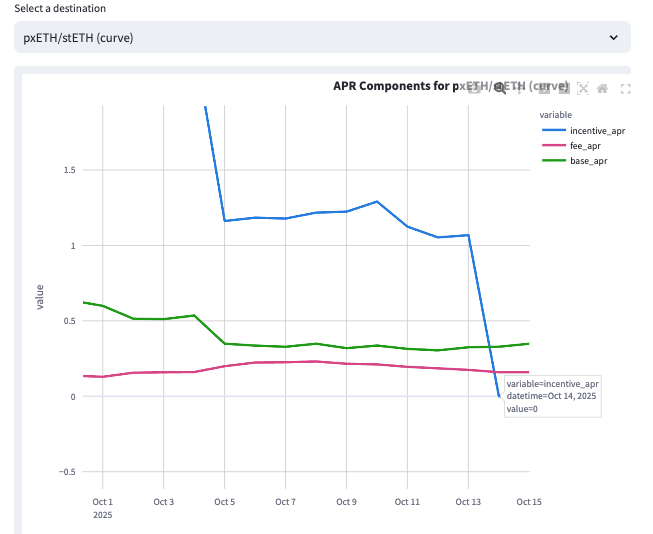

In [ ]:
# can I manually check if rewards are claimable?

In [ ]:
didnt_have_expected_liquidation

In [ ]:
destinations[destinations["destination_vault_address"].isin(didnt_have_expected_liquidation)]

In [ ]:
destination_states[destination_states["destination_vault_address"].isin(didnt_have_expected_liquidation)]

In [ ]:
owned_shares_by_destination = (
    autopool_destination_states[["destination_vault_address", "owned_shares"]]
    .groupby("destination_vault_address")
    .max()
    .reset_index()
)

In [ ]:
def get_list_of_suspect_destinations():
    # a suspect_destination is a destiantion
    # where, the owned shares in the last 3 days is > 1
    # and the incentive apr is > .5
    # and there have been no claim vault rewards in the last 3 days
    pass